In [1]:
import pandas as pd
import numpy as np
import multiprocessing
from random import shuffle
import matplotlib.pyplot as plt
import scikitplot as skplt

In [2]:
X_train_variant_data = pd.read_csv('training_variants')
X_train_variant_data.head()


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
print X_train_variant_data.shape[0]

3321


In [4]:
X_test_variant_data = pd.read_csv('test_variants')
X_test_variant_data.head()

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


In [5]:
X_train_text = pd.read_table('training_text', sep='\|\|', engine='python', names=['ID', 'Text'], skiprows=[0])
X_test_text = pd.read_table('test_text', sep='\|\|', engine='python', names=['ID', 'Text'], skiprows=[0])
X_test_text.head()

,ID,Text
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [6]:
print len(np.unique(X_train_variant_data['Variation']))

2996


In [7]:
"""
    Remove the class target label from the training variant data set and add it to an independent target label array
"""
y_train = X_train_variant_data['Class']
X_train_variant_data.drop('Class', axis=1, inplace=True)
y_train.head()
#print y_train.shape

0    1
1    2
2    2
3    3
4    4
Name: Class, dtype: int64

In [8]:
"""
    One hot encode the target label array
"""

y_train = pd.get_dummies(y_train, prefix='class', prefix_sep='')
y_train.head()


,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0


In [9]:
"""
    Hash vectorize gene, variation columns
"""
from sklearn.feature_extraction.text import HashingVectorizer


X_train_gene = X_train_variant_data['Gene']
gene_hash_vectorizer = HashingVectorizer(n_features=500)
gene_vector = gene_hash_vectorizer.transform(X_train_gene)

X_train_variation = X_train_variant_data['Variation']
variation_hash_vectorizer = HashingVectorizer(n_features=5000)
variation_vector = variation_hash_vectorizer.transform(X_train_variation)

X_test_gene = X_test_variant_data['Gene']
gene_test_hash_vectorizer = HashingVectorizer(n_features=500)
gene_test_vector = gene_test_hash_vectorizer.transform(X_test_gene)

X_test_variation = X_test_variant_data['Variation']
variation_test_hash_vectorizer = HashingVectorizer(n_features=5000)
variation_test_vector = variation_test_hash_vectorizer.transform(X_test_variation)

print gene_vector.shape


(3321, 500)


In [10]:
"""
    Download nltk stopwords corpus
"""
import nltk
nltk.download('popular')

[nltk_data] Downloading collection u'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/paperspace/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/paperspace/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/paperspace/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/paperspace/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/paperspace/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/paperspace/nltk_data...
[nltk_data]    |   Package movie

True

In [11]:
"""
    Process clinical text data by tokenizing words, removing stop words, stemming words etc.
"""

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from gensim import utils
def process_clinical_text(clinical_text):
    stop_words = set(stopwords.words('english'))
    tokenized_text = word_tokenize(utils.to_unicode(clinical_text))
    stemmer = SnowballStemmer('english')
    processed_text = []
    for word in tokenized_text:
        if word not in stop_words:
            processed_text.append(stemmer.stem(word))
    return processed_text

print process_clinical_text('I am of the opinion that there is no guarantee any where in life')    

[u'i', u'opinion', u'guarante', u'life']


In [12]:
"""
    Method to apply doc2vec model on training and test data
"""
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import utils

def apply_doc2vec_model(processed_text):
    cores = multiprocessing.cpu_count()
    epochs = 30

    tagged_clinical_text = []

    for i, text in processed_text.iteritems():
        tagged_clinical_text.append(TaggedDocument(text, ['ct_' + '%s' % str(i)]))

    doc2vec_model = Doc2Vec(dm=1, dm_mean=1, min_count=1, window=5, workers=cores, alpha=0.075, min_alpha=0.075)
    doc2vec_model.build_vocab(tagged_clinical_text)
    
    for i in range(epochs):
        doc2vec_model.train(tagged_clinical_text, total_examples=len(tagged_clinical_text), epochs=1)
        doc2vec_model.alpha -= 0.002
        doc2vec_model.min_alpha = doc2vec_model.alpha
        
    #clinical_text_vector = np.zeros((len(tagged_clinical_text), 300))
    clinical_text_vector = []
    for i in range(len(tagged_clinical_text)):
        clinical_text_vector.append(doc2vec_model.docvecs['ct_'+str(i)])
    
    return clinical_text_vector
    

In [13]:
"""
    Apply Doc2Vec model on the clinical text training and test data
"""

processed_clinical_text = X_train_text['Text'].apply(process_clinical_text)
#print processed_clinical_text[0]
clinical_text_train = apply_doc2vec_model(processed_clinical_text)
#print clinical_text_train[0]
processed_clinical_test_text = X_test_text['Text'].apply(process_clinical_text)
clinical_text_test = apply_doc2vec_model(processed_clinical_test_text)
print clinical_text_test[0]



[ 2.61557007 -1.12856567 -2.59720778 -2.80678248 -0.48065549 -3.20750117
  2.33187985  0.98396945  1.41099131  0.04139038  0.68676567  1.63214707
  1.12991524  0.02724668 -2.17594433 -0.48374206 -2.64634681  0.35164991
  2.32385182 -0.22511473  2.46642828 -0.14161544  1.67595136  1.21365917
 -0.56143421 -0.11172888  1.57000923 -2.24986625  0.66537839 -0.82744163
  0.4604803   0.05626503  1.28072691 -0.5483433  -0.75366694  0.21033999
  2.3632648   0.37246674 -1.53142715  1.12382329  0.84893715  0.08444068
  0.88888896 -0.13185462  1.24280202  1.28584373 -0.01383612  2.94420218
 -0.31765664  0.79701376  1.21045458 -2.16268754  2.40276408  0.28928134
 -0.28753209 -0.58872205  2.33798671 -0.84232914 -0.3703846   3.36535907
  1.70348263 -1.53895211  1.96951687  2.18701053 -0.15753563  1.18287182
 -0.65623903  0.56305104 -0.013279    0.60482359  1.92070258 -1.32621932
 -0.32532528 -1.57295668 -1.3812921   0.43822947  0.39770785  0.41080609
  1.38475537  1.75631618  0.33438393 -0.9517048  -2

In [14]:
#print clinical_text_train.shape


In [17]:
"""
    Combine gene vector, variation vector and clinical text vector into a resultant training set
"""

X_train = np.hstack((gene_vector.toarray(), variation_vector.toarray(), clinical_text_train))
X_test = np.hstack((gene_test_vector.toarray(), variation_test_vector.toarray(), clinical_text_test))

print X_train.shape
print y_train.shape

(3321, 5600)
(3321, 9)


In [18]:
"""
    Expand dimensions of data to fit into the CNN model
"""

X_train_dim_data = np.expand_dims(X_train, axis=2)
print X_train_dim_data.shape
y_train_dim_data = np.array(y_train)
print y_train_dim_data.shape

X_test_dim_data = np.expand_dims(X_test, axis=2)


(3321, 5600, 1)
(3321, 9)


In [19]:
"""
    Define and compile the CNN model
"""

from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential

def create_cnn_model(optimizer='rmsprop'):
    num_classes = 9
    cnn_model = Sequential()
    cnn_model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu', input_shape=X_train_dim_data.shape[1:]))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Dropout(0.2))
    cnn_model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Dropout(0.2))
    cnn_model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Dropout(0.2))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(512, activation='relu'))
    cnn_model.add(Dense(num_classes, activation='softmax'))

    cnn_model.summary()
    cnn_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return cnn_model


Using TensorFlow backend.


In [20]:
"""
    Reshape the training inputs for KFold cross validation inputs
"""
X_train_2d = X_train_dim_data.reshape(X_train_dim_data.shape[0], X_train_dim_data.shape[1])
y_train_2d = y_train_dim_data.reshape(y_train_dim_data.shape[0], y_train_dim_data.shape[1])
print y_train_2d.shape
print y_train_2d[0]

(3321, 9)
[1 0 0 0 0 0 0 0 0]


In [21]:
"""
    Train the CNN model
"""

from keras.callbacks import ModelCheckpoint


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

cnn_model = create_cnn_model()
X_valid_test = X_train_2d[:300]
y_valid_test = y_train_2d[:300]
X_train = X_train_2d[300:]
y_train = y_train_2d[300:]

print X_train_2d.shape
print X_train.shape
X_train = np.expand_dims(X_train, axis=2)
X_valid_test = np.expand_dims(X_valid_test, axis=2)
cnn_model.fit(X_train, y_train, validation_data=(X_valid_test, y_valid_test), epochs=10, batch_size=20, 
        callbacks=[checkpointer], verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 5600, 64)          384       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2800, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2800, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2800, 128)         41088     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1400, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1400, 128)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1400, 256)         164096    
__________

In [22]:
"""
    Load the best weights into the model
"""
cnn_model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [23]:
"""
    Make predictions from test data
"""

model_predictions = cnn_model.predict_proba(X_test_dim_data)

print model_predictions[0]


5668/5668 [==============================] - 6s     
[ 0.11251048  0.32920644  0.02660489  0.20637247  0.05765566  0.03978888
  0.21505165  0.00667574  0.00613386]


In [24]:
y_pred = []
for i in range(len(model_predictions)):
    max_value = model_predictions[i][np.argmax(model_predictions[i])]
    y_pred.append(model_predictions[i] // max_value)



In [25]:
print y_pred[2]

[ 0.  1.  0.  0.  0.  0.  0.  0.  0.]


In [26]:
"""
    Kaggle competition test data set for target class labels are incomplete and as such our test prediction 
    and true values need to be reconciled appropriately. Setting up stage1 test data.
"""
y_true_data = pd.read_csv('stage1_solution_filtered.csv')

y_final_pred = [y_pred[d] for d in y_true_data['ID']]
model_predictions_final = [model_predictions[d] for d in y_true_data['ID']]

y_final_pred_labels = [ np.argmax(pred) + 1 for pred in y_final_pred]
print y_final_pred_labels[0]

y_true_data.drop('ID', axis=1, inplace=True)

y_true_data_labels = [np.argmax(data) + 1 for data in np.array(y_true_data)]
print y_true_data_labels

print len(y_final_pred_labels)
print len(y_true_data_labels)

1
[1, 2, 2, 4, 4, 4, 9, 7, 7, 7, 2, 1, 4, 1, 1, 1, 2, 3, 2, 7, 2, 1, 7, 7, 3, 7, 9, 7, 1, 4, 1, 6, 4, 9, 6, 4, 1, 5, 2, 1, 3, 2, 7, 7, 5, 7, 4, 6, 4, 1, 1, 4, 7, 1, 6, 7, 1, 1, 7, 2, 7, 2, 1, 7, 4, 9, 7, 4, 4, 1, 4, 5, 1, 1, 1, 4, 2, 2, 1, 7, 1, 5, 6, 7, 6, 6, 1, 7, 5, 2, 1, 4, 7, 7, 4, 1, 1, 4, 7, 1, 1, 2, 3, 7, 2, 2, 7, 4, 1, 4, 4, 7, 4, 7, 7, 7, 6, 3, 7, 7, 4, 4, 4, 2, 4, 1, 4, 1, 4, 1, 2, 4, 7, 7, 4, 7, 7, 7, 4, 1, 2, 7, 4, 1, 1, 7, 2, 7, 7, 7, 2, 2, 1, 4, 1, 1, 7, 7, 1, 5, 4, 4, 7, 2, 1, 2, 4, 6, 4, 7, 1, 1, 1, 1, 7, 7, 4, 5, 4, 1, 4, 2, 6, 7, 4, 5, 7, 3, 1, 7, 6, 2, 1, 8, 7, 7, 5, 7, 5, 5, 1, 1, 1, 7, 7, 2, 1, 1, 7, 1, 2, 1, 4, 9, 1, 2, 7, 7, 1, 2, 4, 1, 4, 7, 7, 1, 4, 8, 4, 5, 4, 4, 5, 1, 4, 1, 2, 7, 2, 4, 1, 6, 6, 5, 7, 7, 6, 2, 7, 9, 1, 1, 2, 6, 7, 7, 7, 1, 1, 1, 4, 5, 7, 7, 7, 2, 5, 7, 1, 6, 7, 1, 5, 5, 6, 7, 2, 1, 2, 4, 2, 7, 7, 4, 1, 5, 7, 2, 5, 6, 4, 5, 7, 5, 7, 7, 1, 7, 7, 5, 7, 3, 2, 1, 7, 6, 7, 7, 4, 1, 1, 1, 1, 1, 5, 1, 7, 1, 1, 1, 1, 2, 4, 1, 4, 4, 7, 2, 1, 1, 7, 2, 1

In [27]:
from sklearn.metrics import log_loss
#print model_predictions_final

#print log_loss(y_true_data_labels, model_predictions_final)
print log_loss(np.array(y_true_data), model_predictions_final)

1.46555756129


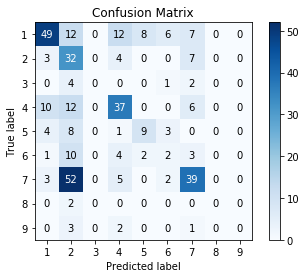

In [28]:
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_true_data_labels, y_final_pred_labels)
plt.show()